## Autograph

* Using AutoGraph is extremely easy: the only thing that you need to do is to annotate your Python code with the special decorator tf.function as in the following code example.

*  there is no need to annotate linear_layer.

In [1]:
import tensorflow as tf
def linear_layer(x):
    return 3 * x + 2
@tf.function
def simple_nn(x):
    return tf.nn.relu(linear_layer(x))
def simple_function(x):
    return 3*x

In [2]:
simple_nn

In [3]:
simple_function

<function __main__.simple_function(x)>

In [4]:
# internal look at the auto-generated code
print(tf.autograph.to_code(simple_nn.python_function, experimental_optional_features=None))

def tf__simple_nn(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('simple_nn', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
    do_return = True
    retval_ = fscope.mark_return_value(ag__.converted_call(tf.nn.relu, (ag__.converted_call(linear_layer, (x,), None, fscope),), None, fscope))
  do_return,
  return ag__.retval(retval_)



* Let's see an example of the difference in speed between code annotated with the tf.function() decorator and the same code with no annotation. Here we use a layer LSTMCell() which will be discussed in Chapter 8, Recurrent Neural Networks, but for now consider it as a black box doing some form of learning:

In [5]:
import tensorflow as tf
import timeit
cell = tf.keras.layers.LSTMCell(100)
@tf.function
def fn(input, state):
    return cell(input, state)
input = tf.zeros([100, 100])
state = [tf.zeros([100, 100])] * 2
# warmup
cell(input, state)
fn(input, state)
graph_time = timeit.timeit(lambda: cell(input, state), number=100)
auto_graph_time = timeit.timeit(lambda: fn(input, state), number=100)
print('graph_time:', graph_time)
print('auto_graph_time:', auto_graph_time)

graph_time: 0.12606661499998495
auto_graph_time: 0.08018681600000832


# Define Model in 3 ways

### 1. Sequential API

In [6]:
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10   # number of outputs = number of digits
N_HIDDEN = 128
RESHAPED = 784

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10,
          input_shape=(RESHAPED,),
          name='dense_layer', activation='relu'))
model.add(tf.keras.layers.Dense(N_HIDDEN,
          name='dense_layer_2', activation='relu'))
model.add(tf.keras.layers.Dense(NB_CLASSES,
          name='dense_layer_3', activation='softmax'))

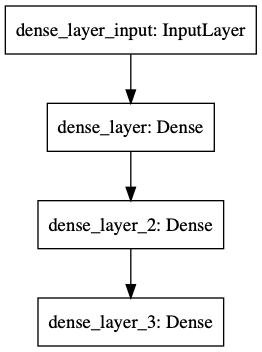

In [8]:
tf.keras.utils.plot_model(model, to_file="model.png")

## Functional API

* The Functional API is useful when you want to build a model with more complex (non-linear) topologies, including multiple inputs, multiple outputs, residual connections with non-sequential flows, and shared and reusable layers. Each layer is callable (with a tensor in input), and each layer returns a tensor as an output. 

In [13]:
import tensorflow as tf
def build_model():
    # variable-length sequence of integers
    text_input_a = tf.keras.Input(shape=(None,), dtype='int32')
    # variable-length sequence of integers
    text_input_b = tf.keras.Input(shape=(None,), dtype='int32')
    # Embedding for 1000 unique words mapped to 128-dimensional vectors
    shared_embedding = tf.keras.layers.Embedding(1000, 128)
    # We reuse the same layer to encode both inputs
    encoded_input_a = shared_embedding(text_input_a)
    encoded_input_b = shared_embedding(text_input_b)
    # two logistic predictions at the end
    prediction_a = tf.keras.layers.Dense(1, activation='sigmoid',\
name='prediction_a')(encoded_input_a)
    prediction_b = tf.keras.layers.Dense(1, activation='sigmoid',\
 name='prediction_b')(encoded_input_b)
    # this model has 2 inputs, and 2 outputs
    # in the middle we have a shared model
    model = tf.keras.Model(inputs=[text_input_a, text_input_b], 
    outputs=[prediction_a, prediction_b])
    tf.keras.utils.plot_model(model, to_file="shared_model.png")
    return model
model = build_model()


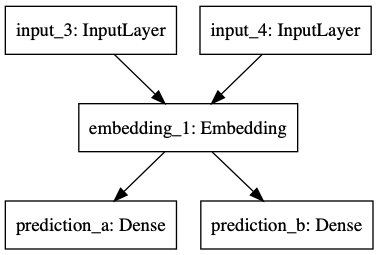

In [14]:
tf.keras.utils.plot_model(model, to_file="model.png")

## 3. Model subclassing

In [16]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                  shape=(input_shape[1], self.output_dim),
                                  initializer='uniform',
                                  trainable=True)
    def call(self, inputs):
        # Do the multiplication and return 
        return tf.matmul(inputs, self.kernel)


In [18]:
model = tf.keras.Sequential([
    MyLayer(20),
    tf.keras.layers.Activation('softmax')])

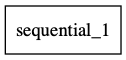

In [19]:
tf.keras.utils.plot_model(model, to_file="model.png")

## Callbacks

Callbacks are objects passed to a model to extend or modify behaviors during training. There are a few useful callbacks that are commonly used in tf.keras:


* tf.keras.callbacks.ModelCheckpoint: This feature is used to save checkpoints of your model at regular intervals and recover in case of problems.


* tf.keras.callbacks.LearningRateScheduler: This feature is used to dynamically change the learning rate during optimization.


* tf.keras.callbacks.EarlyStopping: This feature is used to interrupt training when validation performance has stopped improving after a while.


* tf.keras.callbacks.TensorBoard: This feature is used to monitor the model's behavior using TensorBoard.

## Model Save and load

* Save weights to a Tensorflow Checkpoint file

    model.save_weights('./weights/my_model')
    
    
* Save weights to a HDF5 file

    model.save_weights('my_model.h5', save_format='h5')


* Weights are easily loaded with Restore the model's state

    model.load_weights(file_path)    
    
    
In addition to weights, a model can be serialized in JSON with:

```Python
json_string = model.to_json()  # save 
model = tf.keras.models.model_from_json(json_string) # restore    
```
* If you want to save a model together with its weights and the optimization parameters, then you simply use:

```Python
model.save('my_model.h5') # save
model = tf.keras.models.load_model('my_model.h5') #restore
```